# 개요

- 기본적인 GAN은 간단한 은닉층으로 구성된 신경망이다
- 좀더 강력한 신경망으로 구성한다면
  - 개별 요소 (생성자 혹은 판별자, 조합)등 좀더 좋은 성능을 내는 신경망으로 대체한다면?
  - 생성자 혹은 판별자를 CNN으로 구현한다면
  - ANN -> DNN, .... Deep (심층:은닉층이 2개 이상)
  - 심층 합성곱 GAN : Deep Consolution GAN (DCGAN)

# 모듈가져오기

In [1]:
import tensorflow as tf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 손글씨 이미지 생성 -> 목표, 이 이미지가 가짜임을 잘 분별해 내는것도 -> 목표
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
# DCGAN 구성시 필요한 요소 추가
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

# 환경변수

In [5]:
# 이미지 정보
IMG_ROWS = 28   # h
IMG_COLS = 28   # w
IN_CHANNELS = 1 # 입력 이미지의 채널수
# 입력 이미지 data format : NHWC
# 입력 이미지 형태
IMG_SHAPE   = ( IMG_ROWS, IMG_COLS, IN_CHANNELS )
# 생성기(generator)에 들어가는 노이즈 백터 z의 크기 
Z_DIM       = 100 # 설정값

# 생성자 (Generator)

## 네트워크 구조상 특징

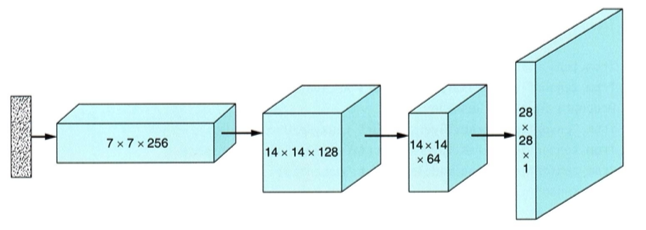

In [6]:
from IPython.display import Image
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/GAN-6-잔치합성곱.png')

# 잡음백터(z) -> ..... -> (28,28,1) : 이미지
# 잡음으로 부터 이미지를 만들어라
# CNN => 이미지 => 분류
# 분류, 재료 => 이미지 : Conv2DTranspose

## 구현

In [13]:
def build_generator( z_dim ):#,  img_shape ):
  '''
    - 생성자 네트워크
    - 잡음백터 (100,) -> ( 256 * 7 * 7, ) -> ( 7, 7, 256) -> (14,14,128) -> (14,14,64) -> (28,28,1)
    - CNN을 이용하여 이미지를 생성한다면, 기존 CNN을 거꾸로 적용하면 된다
      - transposed convolution : 전치 합성곱
    - 백터를 받아서 ( 크기를 늘려서, ...) 이미지를 만든다
  '''
  model = Sequential()

  # (100,) -> ( 256 * 7 * 7, )
  # 100 -> 256*7*7 전결합층 -> Dense
  model.add( Dense(( 256 * 7 * 7 ), input_dim = z_dim) )
  # ( 256 * 7 * 7, ) -> ( 7, 7, 256)
  model.add( Reshape( (7, 7, 256) ) )

  # 전치 합성곱 진행 :  ( 7, 7, 256) -> (14,14,128)
  model.add( Conv2DTranspose(128, kernel_size=3, strides=2, padding='same' ) )
  # 배치 정규화 : BN(BatchNormalization)
  # 데이터들의 평균과 분ㅅ간을 조정 역활
  # 신경망 자체에서 (훈련하는 동안 층간의 입력 분포 변화)공변량 변화을 감소시키는 역활
  model.add( BatchNormalization() )
  # 활성화함수
  model.add( LeakyReLU(alpha=0.01) )

  # (14,14,128) -> (14,14,64)
  model.add( Conv2DTranspose(64, kernel_size=3, strides=1, padding='same' ) )  
  model.add( BatchNormalization() )  
  model.add( LeakyReLU(alpha=0.01) )

  # (14,14,64) ->  (28,28,1)
  # 이미지 크기 확인!!
  model.add( Conv2DTranspose(1, kernel_size=3, strides=2, padding='same') )

  # 활성화 함수 tanh 
  model.add( Activation('tanh') )
  return model
  #pass

In [15]:
a = build_generator( Z_DIM )
a.summary()
# 생성자 훈련 파라미터 : Trainable params: 1,636,737

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

# 판별자 (discriminator)

## 네트워크 구조상 특징

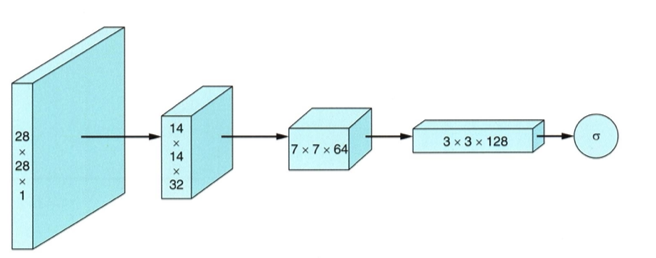

In [8]:
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/GAN-7-판별자.png')
# (28,28,1) -> BN(X),LeakyRelu -> (14,14, 32) -> BN(X),LeakyRelu -> 
#  (7,7,64)-> BN(X),LeakyRelu -> (3, 3, 128) -> BN,LeakyRelu -> Flattern -> sigmoid(0 or 1)

## 구현

In [20]:
def build_discriminator( img_shape ):
  '''
    - 판별자
    - 풀링 제외(컨셉)
    - shape : (28,28,1) -> (14,14, 32) -> BN(X),LeakyRelu 
              -> (7,7,64)-> BN(X),LeakyRelu -> (3, 3, 128) -> BN,LeakyRelu -> Flattern -> sigmoid(0 or 1)
  '''
  model = Sequential()
  # 실습 위의 네트워크 구조대로 신경망을 작성하시오
  # (28,28,1) -> (14,14, 32)
  model.add( Conv2D( 32,   kernel_size=3, strides=2, input_shape=img_shape, padding='same'  ) )
  # BN(X),LeakyRelu
  model.add( LeakyReLU(alpha=0.01) )
  # (14,14, 32) -> (7,7,64)
  model.add( Conv2D( 64,   kernel_size=3, strides=2, padding='same'  ) )
  # BN(X),LeakyRelu
  model.add( LeakyReLU(alpha=0.01) )
  # (7,7,64) -> (3, 3, 128)
  model.add( Conv2D( 128,  kernel_size=3, strides=2, padding='valid' ) )
  # BN,LeakyRelu
  model.add( BatchNormalization() )
  model.add( LeakyReLU(alpha=0.01) )
  # Flattern
  model.add( Flatten() )
  # sigmoid(0 or 1)
  model.add( Dense(1, activation='sigmoid') )
  return model  
  #pass

In [21]:
b = build_discriminator( IMG_SHAPE )
b.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3, 3, 128)        

# 이하 코드는 동일하다

## DCGAN

In [22]:
def build_GAN( generator, discrminator ):  
  model = Sequential()  
  model.add( generator )  
  model.add( discrminator )  
  return model

## 빌드및 컴파일

In [23]:
generator    = build_generator( Z_DIM)

discrminator = build_discriminator( IMG_SHAPE )
discrminator.compile(metrics=['accuracy'] , optimizer=Adam(), loss='binary_crossentropy')
discrminator.trainable = False

gan          = build_GAN( generator, discrminator )
gan.compile(optimizer=Adam(), loss='binary_crossentropy')

## 훈련

In [24]:
losses     = list()
acces      = list()
iterations = list()

def train( iters, batch_size, sInterval ):
  (X_train, _),(_, _) = mnist.load_data()
  X_train = X_train/(255./2) - 1.0
  X_train = np.expand_dims( X_train, axis=3 )
  real    = np.ones(  (batch_size, 1) )
  fake    = np.zeros( (batch_size, 1) )

  for iter in range( iters ):    
    indexs    = np.random.randint( 0, X_train.shape[0], batch_size )
    imgs      = X_train[ indexs ]    
    z         = np.random.normal( 0, 1, (batch_size, Z_DIM) )
    fake_imgs = generator.predict( z )
    d_loss_acc_real    = discrminator.train_on_batch( imgs, real )    
    d_loss_acc_fake    = discrminator.train_on_batch( fake_imgs, fake )    
    d_loss, d_accuracy = np.add( d_loss_acc_real,  d_loss_acc_fake) * 0.5

    z         = np.random.normal( 0, 1, (batch_size, Z_DIM) )    
    _ = generator.predict( z )

    g_loss = gan.train_on_batch( x=z, y=real )
    
    if (iter+1) % sInterval == 0:      
      losses.append( (d_loss, g_loss) )      
      acces.append( d_accuracy * 100.0 )      
      iterations.append( iter+1 )
      print( f'[{iter+1}] d_loss:{ d_loss } , g_loss:{ g_loss }, d_accuracy:{ d_accuracy }' )      
      displayImg( generator )      

In [25]:
def displayImg( generator ):
  image_rows = 4
  image_cols = 4
  z          = np.random.normal( 0, 1, ( image_rows*image_cols, Z_DIM ) )
  fake_imgs  = generator.predict( z )  
  fake_imgs = ( fake_imgs*0.5 ) + 0.5
  fig, axs = plt.subplots( nrows=image_rows, ncols=image_cols, sharex=True, sharey=True, figsize=(4,4) )
  fIndex = 0
  for i in range( image_rows ):
    for j in range( image_cols ):      
      axs[ i,j ].imshow( fake_imgs[ fIndex, : , : , 0 ], cmap='gray' )
      axs[ i,j ].axis('off')
      fIndex += 1

In [ ]:
iteration       = 20000
batch_size      = 128  
sample_interval = 1000
 
train( iteration, batch_size, sample_interval )

11501568/11490434 [==============================] - 0s 0us/step
[1000] d_loss:0.002489186590537429 , g_loss:0.2494608759880066, d_accuracy:1.0
[2000] d_loss:2.4628044684504857e-05 , g_loss:0.007369425147771835, d_accuracy:1.0
[3000] d_loss:3.4774834603013005e-06 , g_loss:0.003305465681478381, d_accuracy:1.0
[4000] d_loss:7.968104398514697e-07 , g_loss:0.0020103678107261658, d_accuracy:1.0
[5000] d_loss:3.785757627383646e-07 , g_loss:0.0013543312670663, d_accuracy:1.0
[6000] d_loss:1.5980166523377193e-07 , g_loss:0.0006179195479489863, d_accuracy:1.0
[7000] d_loss:2.5471850406688645e-08 , g_loss:0.0002588694042060524, d_accuracy:1.0
[8000] d_loss:1.702587937302269e-08 , g_loss:0.00012699795479420573, d_accuracy:1.0
[9000] d_loss:6.182135248167242e-09 , g_loss:0.00012037398118991405, d_accuracy:1.0
[10000] d_loss:4.476167804468023e-09 , g_loss:9.63899219641462e-05, d_accuracy:1.0
[11000] d_loss:5.020158899693428e-09 , g_loss:4.8964720917865634e-05, d_accuracy:1.0
[12000] d_loss:9.502888

In [ ]:
# 손실값 그리기
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot( iterations, losses.T[0], lable='D loss')
plt.plot( iterations, losses.T[1], lable='G loss')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()

In [ ]:
# 정확도 그리기
acces = np.array(acces)

plt.figure(figsize=(15, 5))
plt.plot( iterations, acces, lable='D ACC')

plt.xlabel('iterations')
plt.ylabel('acc')
plt.legend()